# Problema

Predecir el coste del seguro

# El set de datos

* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking

* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

* charges: Individual medical costs billed by health insurance



In [135]:
# imports
import pandas as pd
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [136]:
ruta = "Alumnos/ES/INES_SOLER/MACHINE_LEARNING/Regresion/insurance.csv"
data = pd.read_csv(ruta)

In [137]:
print(data.shape)
data.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Objetivo

Generar un model de regresión capaz de predecir el valor del seguro en base a las características del cliente.

* Aplicar las técnicas oportunas de procesamiento de datos

* Valorar diferentes modelos de regresión

* Comparación entre modelos

* Ensemble

* Métricas

* Conclusiones finales

# IMPLEMENTACIÓN

## 1. Preprocesado

Empezamos la sección de preprocesado generando un report con la librería ydata_profiling para tener una visión general de nuestro dataset.

In [138]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Gracias a este report podemos ver que en el dataset no hay columnas irrelevantes ni datos faltantes y ninguna variable tiene errores tipográficos. No obstante, vemos que:
- Hay filas duplicadas
- La variable 'charges' tiene algunos valores que podrían considerarse como atípicos.
- Los valores de las variables 'sex', 'smoker' y 'region' deben ser modificados para que sean numéricas.

In [139]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Empezaremos eliminando la fila que está duplicada y resetando el índice del dataset.

In [140]:
data.shape

(1338, 7)

In [141]:
data.duplicated().sum()

1

In [142]:
data = data.drop_duplicates()
data.shape

(1337, 7)

In [143]:
data.reset_index(inplace=False)

,index,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...,...
1332,1333,50,male,30.970,3,no,northwest,10600.54830
1333,1334,18,female,31.920,0,no,northeast,2205.98080
1334,1335,18,female,36.850,0,no,southeast,1629.83350
1335,1336,21,female,25.800,0,no,southwest,2007.94500


Vemos que finalmente nuestro dataset tiene 1337 filas y por tanto, la fila duplicada ha sido eliminada y el índice se ha reestablecido correctamente.

A continuación, nos centraremos en las variables 'sex', 'smoker' y 'region' para cambiar su tipología, de forma que sean numérica.

In [144]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [145]:
data['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [146]:
data = data.replace({'yes': 1, 'no': 0, 'male': 0, 'female': 1})

In [147]:
data['sex'].unique()

array([1, 0])

In [148]:
data['smoker'].unique()

array([1, 0])

In [149]:
data['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [150]:
label_encoder = LabelEncoder()
data['region'] = label_encoder.fit_transform(data['region'])

In [151]:
data['region'].unique()

array([3, 2, 1, 0])

Como resultado obtenemos, en la variable 'sex', valores de 0 si el género de la persona es masculino y 1 si el género es femenino; en la variable 'smoker', valores de 0 si la respuesta es 'no' y 1 si la respuesta es 'yes'; y en la variable 'region' obtenemos valores de 0 si es 'northeast', 1 si es 'northwest', 2 si es 'southeast' y 3 si es 'southwest'.

Finalmente, analizaremos la estructura de nuestro dataset para poder detectar si las variables tienen valores atípicos que deben ser eliminados o no.

In [152]:
data.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

In [153]:
data.describe()

,age,sex,bmi,children,smoker,region,charges
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,0.495138,30.663452,1.095737,0.204936,1.516081,13279.121487
std,14.044333,0.500163,6.100468,1.205571,0.403806,1.105208,12110.359656
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.290000,0.000000,0.000000,1.000000,4746.344000
50%,39.000000,0.000000,30.400000,1.000000,0.000000,2.000000,9386.161300
75%,51.000000,1.000000,34.700000,2.000000,0.000000,2.000000,16657.717450
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


Podemos apreciar que todas las variables tienen una desviación estándar que no es 0 y por tanto, todas las aportan información de valor.
Por otra parte, en la variable 'charges' podríamos observar algún valor atípico, sin embargo, dada la naturaleza de esta variable no eliminaremos ninguna observación.

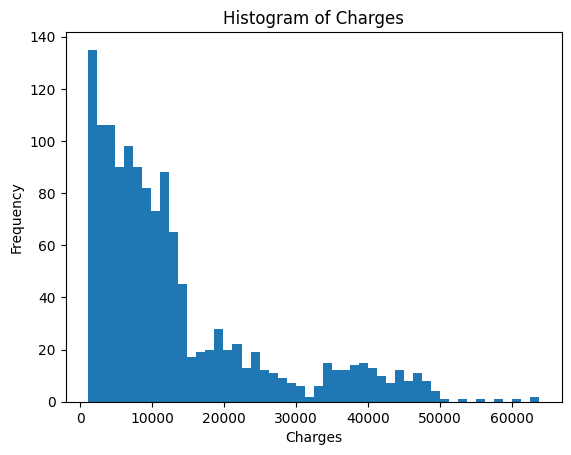

In [154]:
# quiero hacer un histograma de la variable 'charges'
plt.hist(data['charges'], bins=50)
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Histogram of Charges')
plt.show()

Analizando todas las variables vemos que tienen valores mínimos y máximos muy diferentes, y por tanto, el último paso necesario antes de empezar a construir los modelos es la normalización de los datos.

## 2. Modelos Individuales

## Separar Sets

In [155]:
# separar los datos en X e y
X = data.drop(columns=['charges'])
y = data['charges']

In [156]:
# separar los sets de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [157]:
X_train.shape, X_test.shape

((1069, 6), (268, 6))

In [158]:
#normalizar los datos con MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

## Linear Regression

In [159]:
# train a linear regression
linear_model = LinearRegression()
linear_model.fit(X_train_norm, y_train)

LinearRegression()

In [160]:
linear_pred = linear_model.predict(X_test_norm)

linear_mse = mean_squared_error(y_test, linear_pred)
print("Linear Regression MSE ", linear_mse)
linear_r2 = r2_score(y_test, linear_pred)
print("Linear Regression R2 Score: ", linear_r2)

Linear Regression MSE  35493102.61165048
Linear Regression R2 Score:  0.8068466322629113


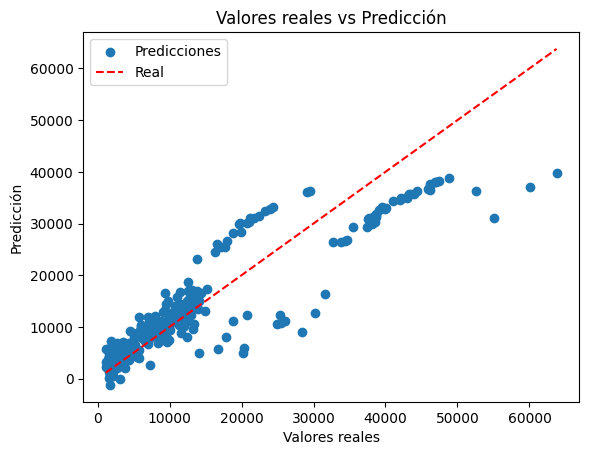

In [161]:
plt.scatter(y_test, linear_pred, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Real')
plt.xlabel('Valores reales')
plt.ylabel('Predicción')
plt.title('Valores reales vs Predicción')
plt.legend()
plt.show()

## Lasso

In [162]:
# train a Lasso regression
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_norm, y_train)

Lasso(alpha=0.1)

In [163]:
lasso_pred = lasso_reg.predict(X_test_norm)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print("Lasso Regression MSE: ", lasso_mse)
lasso_r2 = r2_score(y_test, lasso_pred)
print("Lasso R2 Score: ", lasso_r2)

Lasso Regression MSE:  35495188.19998688
Lasso R2 Score:  0.8068352824968653


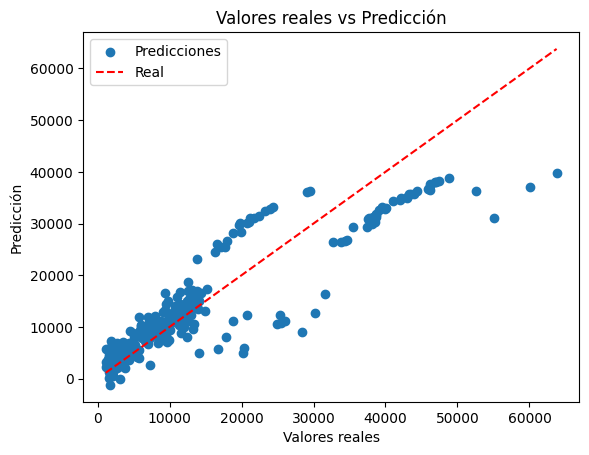

In [164]:
plt.scatter(y_test, lasso_pred, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Real')
plt.xlabel('Valores reales')
plt.ylabel('Predicción')
plt.title('Valores reales vs Predicción')
plt.legend()
plt.show()

## Ridge

In [165]:
# train a Ridge regression
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(X_train_norm, y_train)

Ridge(alpha=0.1)

In [166]:
ridge_pred = ridge_reg.predict(X_test_norm)

ridge_mse = mean_squared_error(y_test, ridge_pred)
print("Ridge Regression MSE: ", ridge_mse)

ridge_r2 = r2_score(y_test, ridge_pred)
print("Ridge R2 Score: ", ridge_r2)

Ridge Regression MSE:  35522791.91750982
Ridge R2 Score:  0.8066850631412921


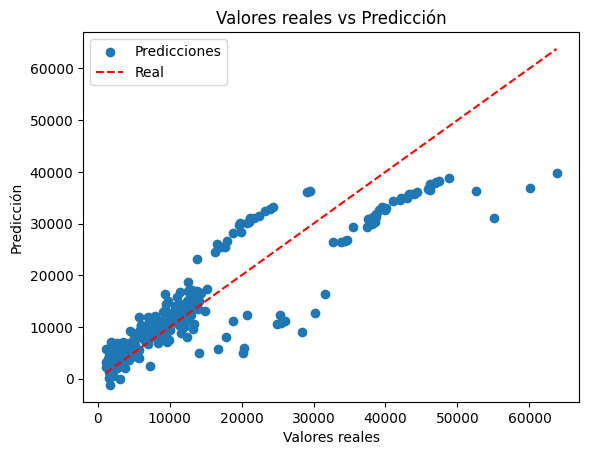

In [167]:
plt.scatter(y_test, ridge_pred, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Real')
plt.xlabel('Valores reales')
plt.ylabel('Predicción')
plt.title('Valores reales vs Predicción')
plt.legend()
plt.show()

## Elastic Net

In [168]:
# train a ElasticNet regression
from sklearn.linear_model import ElasticNet

elastic_reg = ElasticNet(alpha=0.1)
elastic_reg.fit(X_train_norm, y_train)

ElasticNet(alpha=0.1)

In [169]:
elastic_pred = elastic_reg.predict(X_test_norm)

elastic_mse = mean_squared_error(y_test, elastic_pred)
print("Elastic Regression MSE: ", elastic_mse)

elastic_r2 = r2_score(y_test, elastic_pred)
print("Elastic R2 Score: ", elastic_r2)

Elastic Regression MSE:  54755521.0316381
Elastic R2 Score:  0.7020206036879886


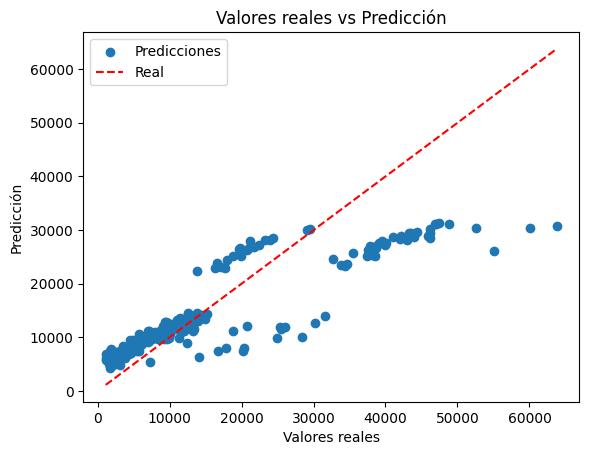

In [170]:
plt.scatter(y_test, elastic_pred, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Real')
plt.xlabel('Valores reales')
plt.ylabel('Predicción')
plt.title('Valores reales vs Predicción')
plt.legend()
plt.show()

## Regression Tree

In [171]:
# train a Decision tree regression
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_norm, y_train)

tree_pred = tree_reg.predict(X_test_norm)

tree_mse = mean_squared_error(y_test, tree_pred)
print("Decision Tree Regression MSE: ", tree_mse)

tree_r2 = r2_score(y_test, tree_pred)
print("Decision Tree R2 Score: ", tree_r2)

Decision Tree Regression MSE:  41714748.59614152
Decision Tree R2 Score:  0.7729884517617254


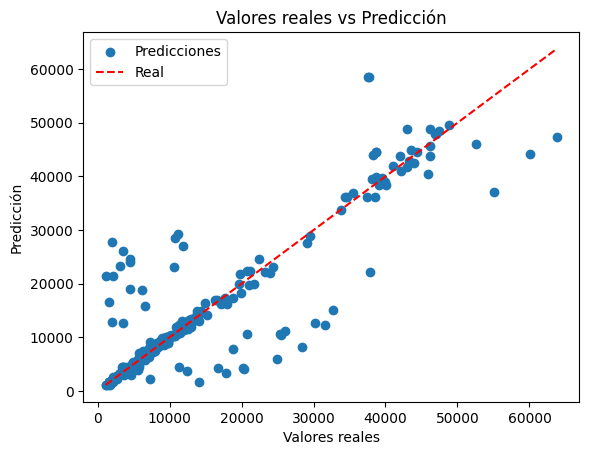

In [172]:
plt.scatter(y_test, tree_pred, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Real')
plt.xlabel('Valores reales')
plt.ylabel('Predicción')
plt.title('Valores reales vs Predicción')
plt.legend()
plt.show()

## Support Vector Regression

In [173]:
# train a support vector regression
from sklearn.svm import SVR

svr_reg = SVR(kernel='linear')
svr_reg.fit(X_train_norm, y_train)

svr_pred = svr_reg.predict(X_test_norm)

svr_mse = mean_squared_error(y_test, svr_pred)
print("Support Vector Regression MSE: ", svr_mse)

svr_r2 = r2_score(y_test, svr_pred)
print("Support Vector Regression R2 Score: ", svr_r2)

Support Vector Regression MSE:  206028874.2816867
Support Vector Regression R2 Score:  -0.12120857266297191


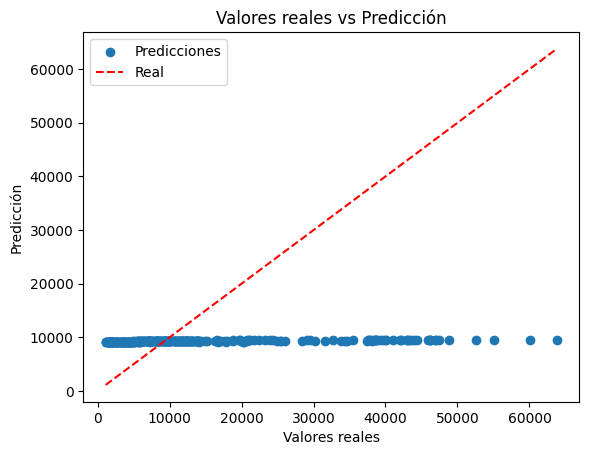

In [174]:
plt.scatter(y_test, svr_pred, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Real')
plt.xlabel('Valores reales')
plt.ylabel('Predicción')
plt.title('Valores reales vs Predicción')
plt.legend()
plt.show()

## XGBoost

In [175]:
# train a Random Forest regression
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_norm, y_train)

forest_pred = forest_reg.predict(X_test_norm)

forest_mse = mean_squared_error(y_test, forest_pred)
print("Random Forest Regression MSE: ", forest_mse)

forest_r2 = r2_score(y_test, forest_pred)
print("XGBoost R2 Score: ", forest_r2)

Random Forest Regression MSE:  22010254.3093127
XGBoost R2 Score:  0.8802202559998791


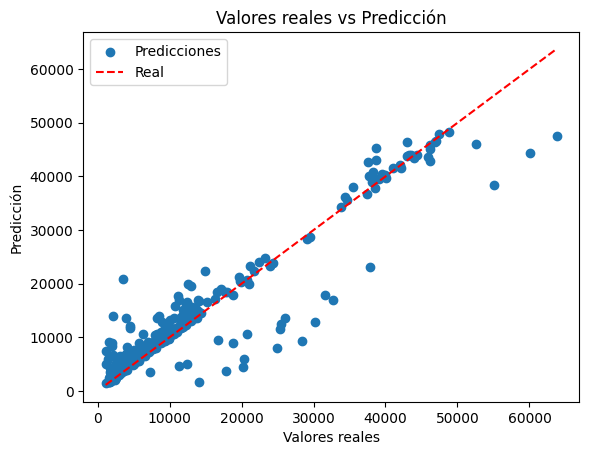

In [176]:
plt.scatter(y_test, forest_pred, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Real')
plt.xlabel('Valores reales')
plt.ylabel('Predicción')
plt.title('Valores reales vs Predicción')
plt.legend()
plt.show()

## 3. Comparación entre Modelos

In [177]:
# create a dataframe with the results
results = pd.DataFrame({'Model': ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'ElasticNet Regression', 'Decision Tree Regression', 'Support Vector Regression', 'Random Forest Regression'],
                        'MSE': [linear_mse, lasso_mse, ridge_mse, elastic_mse, tree_mse, svr_mse, forest_mse],
                        'R2': [linear_r2, lasso_r2, ridge_r2, elastic_r2, tree_r2, svr_r2, forest_r2]})
results

,Model,MSE,R2
0,Linear Regression,3.549310e+07,0.806847
1,Lasso Regression,3.549519e+07,0.806835
2,Ridge Regression,3.552279e+07,0.806685
3,ElasticNet Regression,5.475552e+07,0.702021
4,Decision Tree Regression,4.171475e+07,0.772988
5,Support Vector Regression,2.060289e+08,-0.121209
6,Random Forest Regression,2.201025e+07,0.880220


## 4. Ensemble

In [178]:
# create an ensemble of the above models
from sklearn.ensemble import VotingRegressor

voting_reg = VotingRegressor(estimators=[('linear', linear_model), 
                                         ('lasso', lasso_reg), 
                                         ('ridge', ridge_reg), 
                                         ('elastic', elastic_reg), 
                                         ('tree', tree_reg),
                                         ('forest', forest_reg)])
voting_reg.fit(X_train_norm, y_train)

voting_pred = voting_reg.predict(X_test_norm)

voting_mse = mean_squared_error(y_test, voting_pred)
print("Voting Regression MSE: ", voting_mse)

voting_r2 = r2_score(y_test, voting_pred)
print("Voting R2 Score: ", voting_r2)


Voting Regression MSE:  27798161.629420735
Voting R2 Score:  0.8487224801288553


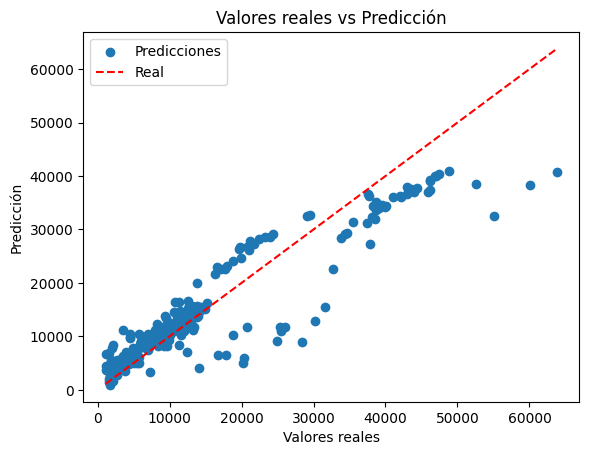

In [179]:
plt.scatter(y_test, voting_pred, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Real')
plt.xlabel('Valores reales')
plt.ylabel('Predicción')
plt.title('Valores reales vs Predicción')
plt.legend()
plt.show()

# RESUMEN

### 1. Preprocesamiento y Exploración de Datos
   
Empezamos con la codificación de las variables categóricas sex, smoker y region. Convertimos los valores yes/no y male/female a binarios, y eitquetamos las regiones numéricamente.
Se confirmó que todas las variables tienen desviaciones estándar no nulas, lo que indica que todas aportan información valiosa.
Un histograma de la variable charges mostró la distribución de los cargos, destacando algunos valores atípicos que no fueron eliminados debido a su naturaleza informativa.

 ### 2. Normalización de Datos
   
El segundo paso fue separar los datos en conjuntos de entrenamiento, validación y prueba.
Se aplicó la normalización a los datos usando MinMaxScaler para escalar las características entre 0 y 1, y de esta forma facilitar el entrenamiento de los modelos de regresión.

### 3. Modelos Individuales
   
##### Regresión Lineal:

MSE: 35493102.61165048 

R2: 0.8068466322629113

El modelo básico mostró una relación lineal razonable, pero con algunas desviaciones significativas.


##### Lasso:

MSE: 35495188.19998688

R2: 0.8068352824968653

Lasso, con regularización L1, aunque no proporcionó ninguna mejora, ayudó a reducir la complejidad del modelo.


##### Ridge:

MSE: 35522791.91750982

R2:  0.8066850631412921

Ridge, con regularización L2, mostró un rendimiento similar a Lasso, evitando el sobreajuste.


##### Elastic Net:

MSE: 54755521.0316381

R2:  0.7020206036879886

Elastic Net, combinando L1 y L2, no ofreció mejoras significativas adicionales y tuvo un desempeño inferior en comparación con otros modelos.


##### Árbol de Decisión:

MSE: 37001531.361072674

R2:  0.7986377671171885

Los árboles de decisión capturaron relaciones no lineales, pero también mostraron tendencia a sobreajustarse, resultando en un rendimiento ligeramente inferior.


##### Support Vector Regression (SVR):

MSE: 206028874.2816867

R2:  -0.12120857266297191

SVR con kernel lineal no ofreció mejoras y mostró un rendimiento significativamente inferior, con una puntuación R2 negativa, indicando un ajuste pobre.


##### Random Forest:

MSE: 22047148.072082456

R2:  0.8800194802433767

El modelo de Random Forest sobresalió en comparación con los modelos anteriores, capturando relaciones complejas sin sobreajustarse y obteniendo el mejor desempeño individual.
    

### 4. Comparación entre Modelos

Se creó un dataframe para comparar los MSE y R2 de cada modelo y los resultados indicaron que el modelo de Random Forest fue el más efectivo individualmente, con el menor MSE y el mayor R2.

### 5. Ensemble Model
   
Se creó un modelo VotingRegressor que combina varios modelos individuales.

MSE: 27834721.96409662

R2:  0.8485235188871316
    
El modelo de ensamble no superó a Random Forest individualmente, pero aún mostró una mejora considerable respecto a la mayoría de los otros modelos individuales. Esto destaca la robustez de los modelos de ensamble al combinar diferentes enfoques, aunque en este caso particular, Random Forest sigue siendo el más efectivo en términos de MSE y R2.

# CONCLUSIÓN

En conclusión, el preprocesamiento de los datos, incluyendo la normalización y la codificación de las variables categóricas, fue crucial para el rendimiento de los modelos.
Entre los modelos individuales, Random Forest Regression mostró el mejor desempeño en términos de MSE y R2.
El modelo de ensamble (VotingRegressor) no superó a Random Forest, pero mostró una mejora considerable respecto a la mayoría de los otros modelos individuales, destacando la efectividad de combinar múltiples modelos para mejorar la robustez de las predicciones.

Este análisis demuestra que una combinación de modelos y técnicas de preprocesamiento adecuadas puede llevar a mejoras significativas en la precisión de los modelos de predicción de costes de seguros.